<a href="https://colab.research.google.com/github/brucebra000/DS-Unit-2-Applied-Modeling/blob/master/U2S3A3_Model_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Model Interpretation 1

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

If you have not yet completed an initial model yet for your portfolio project, you can do today's assignment using your Tanzania Waterpumps model. An example solution will be provided.

**Multi-class classification** will result in multiple Partial Dependence Plots (one for each class).

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [0]:
import sys
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from pdpbox import pdp
from google.colab import files

In [0]:
%%capture
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [5]:
upload = files.upload()

Saving rotten_tomatoes_movies.csv to rotten_tomatoes_movies.csv


In [27]:
df = pd.read_csv('rotten_tomatoes_movies.csv')
print(df.shape)
df.head()

(16638, 23)


,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,poster_image_url,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count
0,/m/0814255,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,https://resizing.flixster.com/p1veUpQ4ktsSHtRu...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,Spilled,53.0,254287.0,38,71,73
1,/m/0878835,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,https://resizing.flixster.com/0AbudQ4KsB4BeXSB...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,Upright,64.0,11567.0,43,121,19
2,/m/10,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,https://resizing.flixster.com/mF0dxH6UTa0FdkMs...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,Spilled,53.0,14670.0,2,15,7
3,/m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,https://resizing.flixster.com/u-8xAyGaDVvROLiR...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,Upright,97.0,105000.0,6,51,0
4,/m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",https://resizing.flixster.com/FKExgYBHu07XLoil...,G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,Upright,74.0,68860.0,5,24,3


In [28]:
#cleaning the data
clean_df = df
dropped_features = ['rotten_tomatoes_link', 'movie_title', 'movie_info', 'poster_image_url', 'tomatometer_rating', 'critics_consensus', 'genre', 'cast']
clean_df = clean_df.drop(columns = dropped_features)

clean_df = clean_df.dropna(axis = 0)

print(clean_df.shape)
clean_df.head()

(14181, 15)


,rating,directors,writers,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_count,audience_status,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count
0,PG,Chris Columbus,Craig Titley,2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,144,Spilled,53.0,254287.0,38,71,73
1,R,Nicole Holofcener,Nicole Holofcener,2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,140,Upright,64.0,11567.0,43,121,19
2,R,Blake Edwards,Blake Edwards,1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,22,Spilled,53.0,14670.0,2,15,7
3,NR,Sidney Lumet,Reginald Rose,1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,51,Upright,97.0,105000.0,6,51,0
4,G,Richard Fleischer,Earl Felton,1954-01-01,2003-05-20,127.0,Disney,Fresh,27,Upright,74.0,68860.0,5,24,3


In [29]:
#Train, Val, and Test sets
train, test = train_test_split(clean_df, stratify = clean_df['tomatometer_status'], random_state = 1)
train, val = train_test_split(train, stratify = train['tomatometer_status'], random_state = 1)
train.shape, val.shape, test.shape

((7976, 15), (2659, 15), (3546, 15))

In [0]:
#Features matrix and target vector
target = 'tomatometer_status'
x_train = train.drop(columns = target)
y_train = train[target]
x_val = val.drop(columns = target)
y_val = val[target]
x_test = test.drop(columns = target)
y_test = test[target]

In [31]:
#Fitting a model
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators = 100, random_state = 1, n_jobs = -1)
)

pipeline.fit(x_train, y_train)
print('Validation Accuracy Score:', pipeline.score(x_val, y_val))

Validation Accuracy Score: 0.9740503948852952


In [32]:
#Partial Dependence Plot
encoder = ce.OrdinalEncoder()
x_encoded = encoder.fit_transform(x_train)

model = RandomForestClassifier(n_estimators = 100, random_state = 1, n_jobs = -1)
model.fit(x_encoded, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

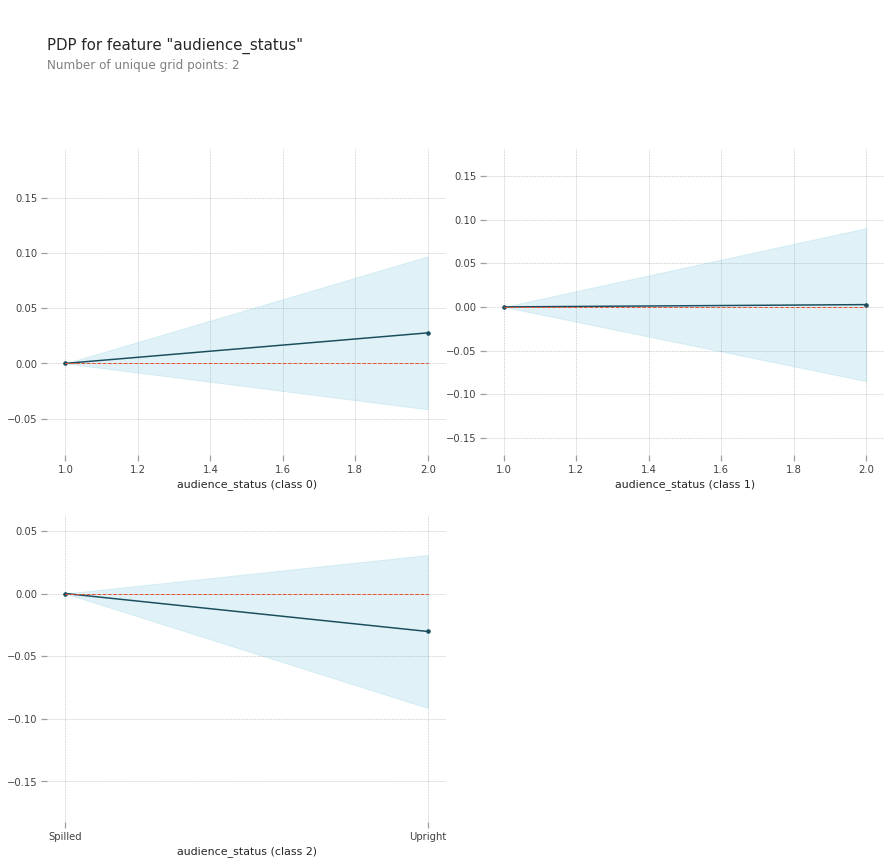

In [33]:
%matplotlib inline
sns.set()

feature = 'audience_status'
features = clean_df.columns.drop([target])

pdp_dist = pdp.pdp_isolate(model = model, dataset = x_encoded, model_features = features, feature = feature)
pdp.pdp_plot(pdp_dist, feature)
plt.xticks([1, 2], ['Spilled', 'Upright']);

In [34]:
encoder.mapping

[{'col': 'rating', 'data_type': dtype('O'), 'mapping': R         1
  NR        2
  PG        3
  PG-13     4
  G         5
  NC17      6
  R)        7
  PG-13)    8
  NaN      -2
  dtype: int64},
 {'col': 'directors',
  'data_type': dtype('O'),
  'mapping': Mike Figgis                                        1
  Abe Forsythe                                       2
  Mike Cahill                                        3
  Eric Schaeffer                                     4
  Joel Schumacher                                    5
                                                  ... 
  Quinn Costello, Chris Metzler, Jeff Springer    4647
  Aaron Norris                                    4648
  Aaron Wilson                                    4649
  Anurag Kashyap                                  4650
  NaN                                               -2
  Length: 4651, dtype: int64},
 {'col': 'writers',
  'data_type': dtype('O'),
  'mapping': Eric Roth, Michael Cristofer                    